# EDA of the book and trade data

# read data

In [5]:
import pandas as pd

date = "20220801"
try:
    bookupdates = pd.read_csv(date + '_book_updates.csv')
    trades = pd.read_csv(date + '_trades.csv')
except Exception as e:
    print("Error:", e)

In [6]:
bookupdates.head()

,COLLECTION_TIME,MESSAGE_ID,MESSAGE_TYPE,SYMBOL,BID_PRICE_1,BID_SIZE_1,BID_PRICE_2,BID_SIZE_2,BID_PRICE_3,BID_SIZE_3,ASK_PRICE_1,ASK_SIZE_1,ASK_PRICE_2,ASK_SIZE_2,ASK_PRICE_3,ASK_SIZE_3
0,2022-08-01 13:30:00.172841984,326282,BID_UPDATE,SPY,409.03,100,408.99,100,327.31,100,409.17,7,409.72,50,409.92,100
1,2022-08-01 13:30:00.173193984,326337,BID_UPDATE,SPY,409.03,100,409.00,100,408.99,100,409.17,7,409.72,50,409.92,100
2,2022-08-01 13:30:00.175386112,326589,ASK_UPDATE,SPY,409.03,100,409.00,100,408.99,100,409.15,500,409.17,7,409.72,50
3,2022-08-01 13:30:00.175386112,326613,ASK_UPDATE,SPY,409.03,100,409.00,100,408.99,100,409.17,7,409.72,50,409.92,100
4,2022-08-01 13:30:00.176423936,326726,ASK_UPDATE,SPY,409.03,100,409.00,100,408.99,100,409.17,7,409.72,50,409.92,100


In [7]:
trades.head()

,COLLECTION_TIME,MESSAGE_ID,MESSAGE_TYPE,SYMBOL,PRICE,SIZE,TRADE_ID,TRADE_FLAGS
0,2022-08-01 13:18:42.396890880,244433,T,SPY,409.17,100,18685253,EXTENDED_HOURS
1,2022-08-01 13:19:52.738202880,248890,T,SPY,409.07,100,19127856,EXTENDED_HOURS
2,2022-08-01 13:19:52.738856960,248891,T,SPY,409.07,200,19127865,EXTENDED_HOURS
3,2022-08-01 13:30:00.315073024,342586,T,SPY,409.17,7,25037432,INTERMARKET_SWEEP|REGULAR_HOURS|ODD_LOT|TRADE_...
4,2022-08-01 13:30:00.318130944,342604,T,SPY,409.17,3,25039337,INTERMARKET_SWEEP|REGULAR_HOURS|ODD_LOT|TRADE_...


# basic introduction

MESSAGE_TYPE:

MESSAGE_TYPE indicates the update of trade/ask in status bookupdates csv file

MESSAGE_TYPE indicates that a trade happened in the trades csv file

market depth:

The book data contains 3 levels on the bid side and 3 levels on the ask side.

trade flag explanation:

EXTENDED_HOURS: Trade occurred besides Regular Market Session

REGULAR_HOURS: Trade occurred during Regular Market Session

ODD_LOT: Trade is less than one round lot

INTERMARKET_SWEEP: Trade resulted from an ISO

TRADE_THROUGH_EXEMPT: Trade is not subject to Trade Through Rull 611 of SEC Reg. NMS

SINGLE_PRICE_CROSS:Trade resulted from a single-price cross

Spread:

The spread is the difference between the bid and the ask price. It can be thought of as the transaction cost for immediate (or near-immediate) trades. A smaller spread often indicates a more liquid market, while a larger spread can indicate lower liquidity.

Order Flow Imbalance:

Order Flow Imbalance (OFI) is a concept in financial markets that refers to an asymmetry between the number of buy (bid) and sell (ask) orders at a given time. It's a measure used to gauge the pressure exerted by buyers and sellers on the price of a security. Understanding OFI is particularly relevant in market microstructure analysis and for traders, including those involved in high-frequency trading (HFT), as it can provide insights into the short-term price movements of a security.

Voulume Weighted Average Price:

VWAP is often used as a trading benchmark by institutions and traders to ensure they're getting a favorable price compared to the market.


# Market Trade Analytics

Aggregate the trades into seconds and minutes

In [15]:
trades_agg = trades.groupby(['SYMBOL', trades['COLLECTION_TIME'].str[:16]]).agg({'SIZE': 'sum', 'PRICE': lambda x: (x * trades.loc[x.index, 'PRICE']).sum() / x.sum()}).reset_index()
trades_agg['COLLECTION_TIME'] = pd.to_datetime(trades_agg['COLLECTION_TIME'])
trades_agg = trades_agg.sort_values(by='COLLECTION_TIME')
print(trades_agg)

    SYMBOL     COLLECTION_TIME   SIZE       PRICE
0      SPY 2022-08-01 13:18:00    100  409.170000
1      SPY 2022-08-01 13:19:00    300  409.070000
2      SPY 2022-08-01 13:30:00  12601  409.365178
3      SPY 2022-08-01 13:31:00  47782  409.215211
4      SPY 2022-08-01 13:32:00   4113  408.718434
..     ...                 ...    ...         ...
393    SPY 2022-08-01 20:37:00    100  410.850000
394    SPY 2022-08-01 20:48:00    300  410.910000
395    SPY 2022-08-01 20:50:00    300  410.910000
396    SPY 2022-08-01 20:51:00    200  410.875000
397    SPY 2022-08-01 20:55:00    200  410.930000

[398 rows x 4 columns]


ticker correlation heatmap

In [16]:
grouped=trades_agg.groupby('SYMBOL')
trades_agg['returns'] = grouped['PRICE'].pct_change()
trades_agg['returns'].fillna(0, inplace=True)

print(trades_agg.head())


  SYMBOL     COLLECTION_TIME   SIZE       PRICE   returns
0    SPY 2022-08-01 13:18:00    100  409.170000  0.000000
1    SPY 2022-08-01 13:19:00    300  409.070000 -0.000244
2    SPY 2022-08-01 13:30:00  12601  409.365178  0.000722
3    SPY 2022-08-01 13:31:00  47782  409.215211 -0.000366
4    SPY 2022-08-01 13:32:00   4113  408.718434 -0.001214


<Axes: xlabel='SYMBOL', ylabel='SYMBOL'>

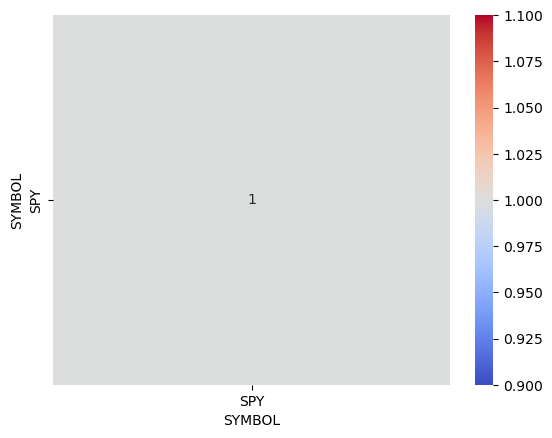

In [17]:
import seaborn as sns

corr = trades_agg.pivot_table(index='COLLECTION_TIME', columns='SYMBOL', values='returns')
sns.heatmap(corr.corr(), annot=True, cmap='coolwarm')


## Market Depth Analytics

plot the depth of the 5 most liquid tickers

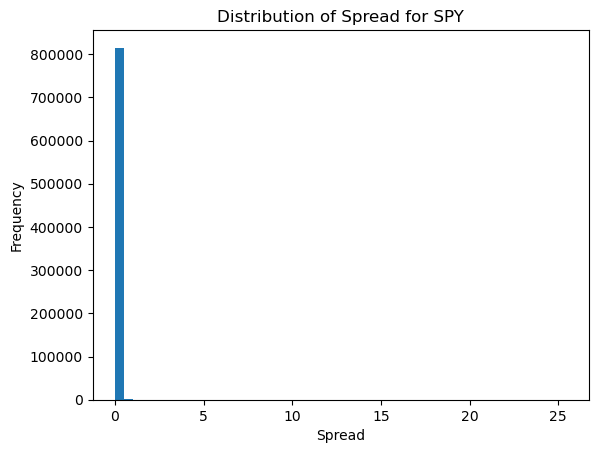

In [22]:
import matplotlib.pyplot as plt
import datetime
trade_sizes_sum = trades.groupby('SYMBOL')['SIZE'].sum().sort_values(ascending=False).head(10)
most_traded = trade_sizes_sum.index.tolist()[:5]

for symbol in most_traded:
    symbol_data = bookupdates[bookupdates['SYMBOL'] == symbol]
    symbol_data['spread'] = symbol_data['ASK_PRICE_1'] - symbol_data['BID_PRICE_1']
    plt.hist(symbol_data['spread'], bins=50)
    plt.title(f"Distribution of Spread for {symbol}")
    plt.xlabel("Spread")
    plt.ylabel("Frequency")
    plt.show()


Plot the OFI of the 5 most liquid tickers

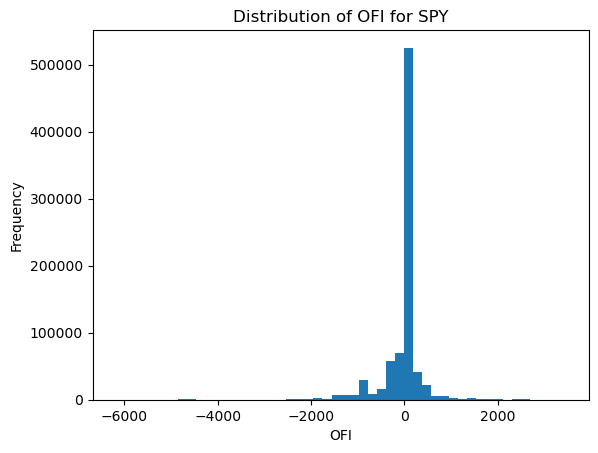

In [23]:
for symbol in most_traded:
    symbol_data = bookupdates[bookupdates['SYMBOL'] == symbol]
    symbol_data['ofi'] = (symbol_data['BID_SIZE_1'] + symbol_data['BID_SIZE_2'] + symbol_data['BID_SIZE_3']) - \
                          (symbol_data['ASK_SIZE_1'] + symbol_data['ASK_SIZE_2'] + symbol_data['ASK_SIZE_3'])
    plt.hist(symbol_data['ofi'], bins=50)
    plt.title(f"Distribution of OFI for {symbol}")
    plt.xlabel("OFI")
    plt.ylabel("Frequency")
    plt.show()

Plot the Bid Depth of the 5 most liquid tickers

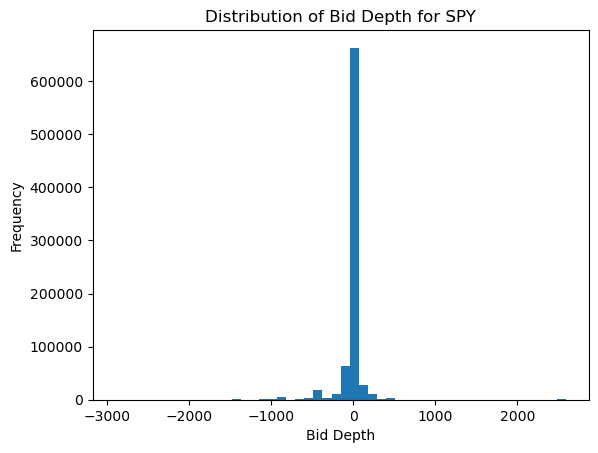

In [24]:
for symbol in most_traded:
    symbol_data = bookupdates[bookupdates['SYMBOL'] == symbol]
    symbol_data['bid_depth'] = symbol_data['BID_SIZE_3'] - symbol_data['BID_SIZE_1']
    plt.hist(symbol_data['bid_depth'], bins=50)
    plt.title(f"Distribution of Bid Depth for {symbol}")
    plt.xlabel("Bid Depth")
    plt.ylabel("Frequency")
    plt.show()
    


Plot the Ask Depth of the 5 most liquid tickers

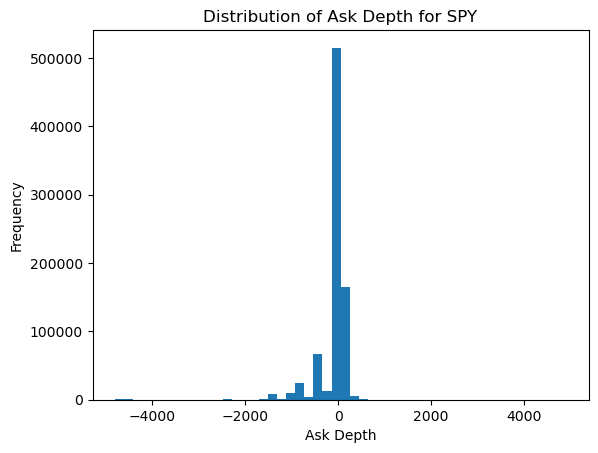

In [25]:
for symbol in most_traded:
    symbol_data = bookupdates[bookupdates['SYMBOL'] == symbol]
    symbol_data['ask_depth'] = symbol_data['ASK_SIZE_3'] - symbol_data['ASK_SIZE_1']
    plt.hist(symbol_data['ask_depth'], bins=50)
    plt.title(f"Distribution of Ask Depth for {symbol}")
    plt.xlabel("Ask Depth")
    plt.ylabel("Frequency")
    plt.show()

Plot the Voulume Weighted Average Price of the 5 most liquid tickers

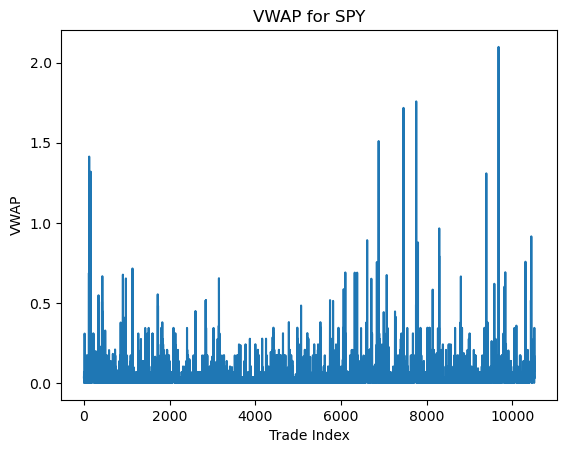

In [26]:
for symbol in most_traded:
    symbol_data = trades[trades['SYMBOL'] == symbol]
    symbol_data['VWAP'] = symbol_data['PRICE'] * symbol_data['SIZE'] / trade_sizes_sum[symbol]

    plt.plot(symbol_data['VWAP'])
    plt.title(f"VWAP for {symbol}")
    plt.xlabel("Trade Index")
    plt.ylabel("VWAP")
    plt.show()
